In [23]:
! pip install scikit-learn-extra rdkit plotly

In [24]:
# Importar bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.neighbors import NearestNeighbors

In [25]:
# ---------------------------------------------------
# 1. Carregar a base de dados (IoT_5000)
# ---------------------------------------------------
df = pd.read_csv('dispositivos_iot_5000.csv')

# ---------------------------------------------------
# 2. Pré-processamento: Normalizar as variáveis
# ---------------------------------------------------
X = df[['x', 'y', 'consumo_watts']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

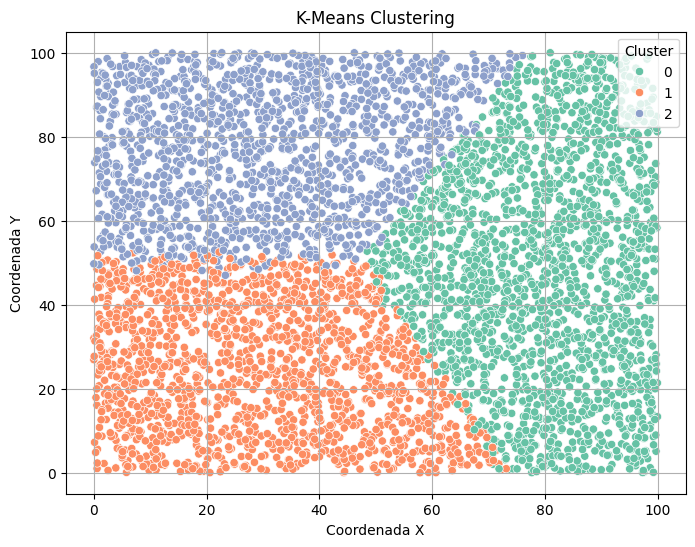

Silhouette Score (K-Means): 0.243


In [26]:
# ---------------------------------------------------
# 3. Aplicar K-Means
# ---------------------------------------------------
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
score_kmeans = silhouette_score(X_scaled, df['kmeans_cluster'])

# Visualizar K-Means
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='x', y='y', hue='kmeans_cluster', palette='Set2')
plt.title('K-Means Clustering')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

print('Silhouette Score (K-Means):', round(score_kmeans, 3))




# # KMeans com inicialização aleatória
# kmeans = KMeans(n_clusters=3, init='random', random_state=0)
# kmeans_labels = kmeans.fit_predict(X_scaled)

# # KMeans++
# kmeans_pp = KMeans(n_clusters=3, init='k-means++', random_state=0)
# kmeans_pp_labels = kmeans_pp.fit_predict(X_scaled)


# # K-Medoids
# kmedoids = KMedoids(n_clusters=3, method='pam', random_state=0)
# kmedoids_labels = kmedoids.fit_predict(X_scaled)

# # Atribuindo ao DataFrame
# df['kmeans'] = kmeans_labels
# df['kmeans++'] = kmeans_pp_labels
# df['kmedoids'] = kmedoids_labels




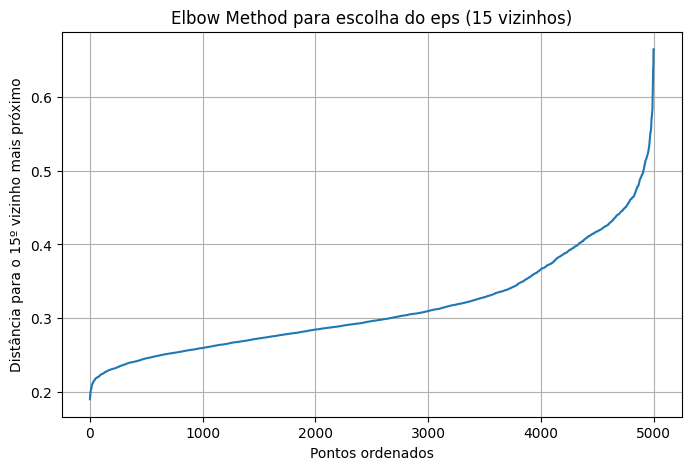

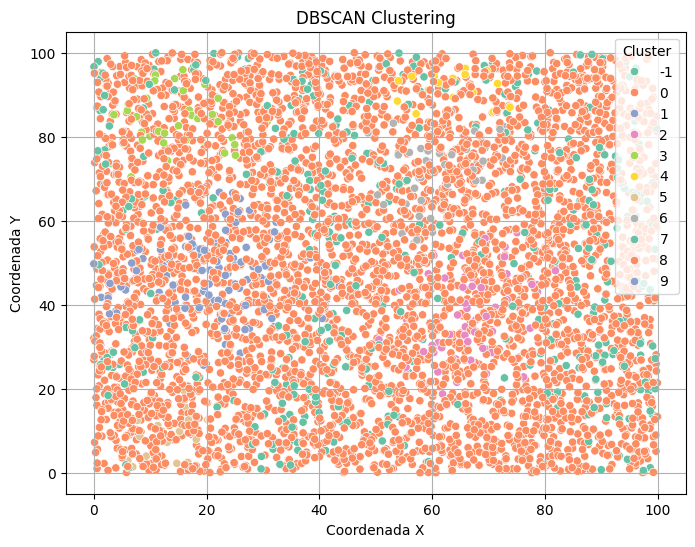

Silhouette Score (DBSCAN): 0.033


In [27]:

# ---------------------------------------------------
# 4.1 Estimar melhor valor de eps com gráfico de cotovelo
# ---------------------------------------------------


neigh = NearestNeighbors(n_neighbors=15)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Pegar a 15ª distância (última de cada linha) e ordenar
distances = np.sort(distances[:, -1])
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title('Elbow Method para escolha do eps (15 vizinhos)')
plt.xlabel('Pontos ordenados')
plt.ylabel('Distância para o 15º vizinho mais próximo')
plt.grid(True)
plt.show()

# ---------------------------------------------------
# 4. Aplicar DBSCAN
# ---------------------------------------------------
dbscan = DBSCAN(eps=0.37, min_samples=15)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled)

# Visualizar DBSCAN
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='x', y='y', hue='dbscan_cluster', palette='Set2')
plt.title('DBSCAN Clustering')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

# Silhouette Score para DBSCAN (se possível)
if len(set(df['dbscan_cluster'])) > 1 and -1 in df['dbscan_cluster'].values:
    dbscan_mask = df['dbscan_cluster'] != -1
    score_dbscan = silhouette_score(X_scaled[dbscan_mask], df['dbscan_cluster'][dbscan_mask])
    print('Silhouette Score (DBSCAN):', round(score_dbscan, 3))
else:
    score_dbscan = None
    print('DBSCAN não formou clusters válidos para cálculo de Silhouette Score.')

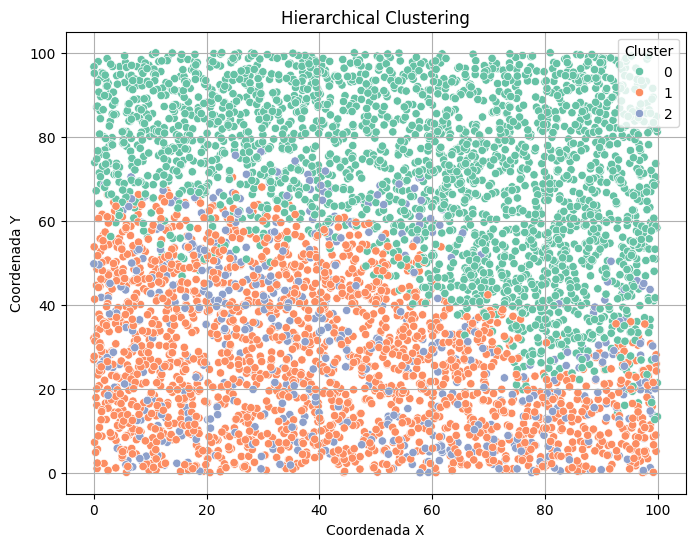

Silhouette Score (Hierárquico): 0.214


In [28]:

# ---------------------------------------------------
# 5. Aplicar Clusterização Hierárquica
# ---------------------------------------------------
agglo = AgglomerativeClustering(n_clusters=3)
df['agglo_cluster'] = agglo.fit_predict(X_scaled)
score_agglo = silhouette_score(X_scaled, df['agglo_cluster'])

# Visualizar Hierárquico
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='x', y='y', hue='agglo_cluster', palette='Set2')
plt.title('Hierarchical Clustering')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

print('Silhouette Score (Hierárquico):', round(score_agglo, 3))

     Algoritmo  Silhouette Score
0      K-Means          0.242724
2  Hierárquico          0.213949
1       DBSCAN          0.032934


<ipython-input-29-e020c1663c38>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=resultados, x='Algoritmo', y='Silhouette Score', palette='Set2')


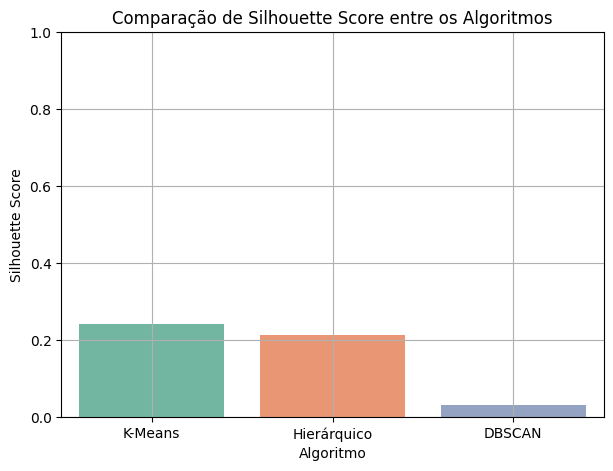

In [29]:

# ---------------------------------------------------
# 6. Comparação dos Métodos
# ---------------------------------------------------
resultados = pd.DataFrame({
    'Algoritmo': ['K-Means', 'DBSCAN', 'Hierárquico'],
    'Silhouette Score': [score_kmeans, score_dbscan if score_dbscan else np.nan, score_agglo]
})

resultados = resultados.sort_values(by='Silhouette Score', ascending=False)
print(resultados)

# Gráfico comparativo
plt.figure(figsize=(7,5))
sns.barplot(data=resultados, x='Algoritmo', y='Silhouette Score', palette='Set2')
plt.title('Comparação de Silhouette Score entre os Algoritmos')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

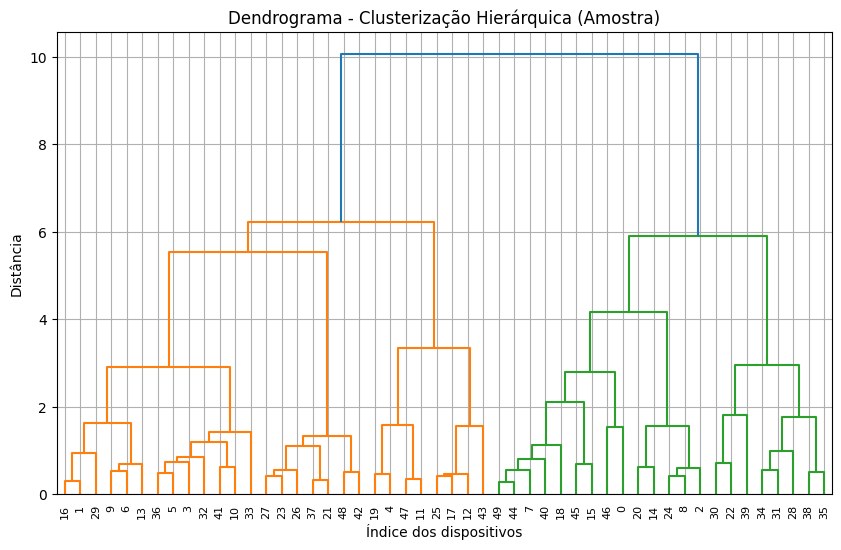

In [30]:
# ---------------------------------------------------
# 7. Dendrograma Hierárquico para Exploração
# ---------------------------------------------------
# Selecionar pequena amostra para visualização
df_sample = df.sample(n=50, random_state=42)
X_sample_scaled = scaler.fit_transform(df_sample[['x', 'y', 'consumo_watts']])
linked = linkage(X_sample_scaled, method='ward')

plt.figure(figsize=(10,6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title("Dendrograma - Clusterização Hierárquica (Amostra)")
plt.xlabel("Índice dos dispositivos")
plt.ylabel("Distância")
plt.grid(True)
plt.show()


In [31]:
#  Calcula distância euclidiana ao PB em (0,0)
df['euclid_dist'] = np.sqrt(df['x']**2 + df['y']**2)


In [32]:

# média de distância por cluster, do mais próximo ao mais distante
cluster_order = (
    df
    .groupby('kmeans_cluster')['euclid_dist']
    .mean()
    .sort_values()
    .index
    .tolist()
)

In [33]:
new_order = []
for cl in cluster_order:
    # pega índices do cluster 'cl' ordenados por distância
    idxs = (
        df[df['kmeans_cluster']==cl]
        .sort_values('euclid_dist')
        .index
        .tolist()
    )
    new_order.extend(idxs)


In [34]:
# Reordena o DataFrame e atribui ordem de carregamento
df_reordered = df.loc[new_order].reset_index(drop=True)
df_reordered['load_order'] = df_reordered.index + 1

In [35]:
print(df_reordered[['kmeans_cluster','euclid_dist','load_order']].head(10))

   kmeans_cluster  euclid_dist  load_order
0               1     1.158033           1
1               1     2.388869           2
2               1     2.582065           3
3               1     2.849365           4
4               1     4.060810           5
5               1     4.857097           6
6               1     5.628975           7
7               1     5.784984           8
8               1     5.993314           9
9               1     6.158397          10


Clusterização: o K-Means agrupou dispositivos que têm perfil semelhante de posição e consumo.

Ordem entre clusters: carregamos primeiro o cluster cuja média de distância ao PB é menor (menor path‐loss, logo maior eficiência).

Ordem dentro do cluster: entre os “próximos”, carregamos primeiro os mais próximos ao PB (minimizando perdas e equilibrando o sistema).

In [37]:
# --- 3) Parâmetros do modelo WET ---
K       = len(df_reordered)
N       = 10
c, f    = 3e8, 9.15e8
alpha   = 2.7
k_factor= 1.5
max_pot = 10.73
a, b    = 0.238, 5.365
omega   = 3.6999688879e-3
Em      = 200
Pt      = 3

# --- 4) Vetores reordenados ---
d_k = df_reordered['euclid_dist'].values

# --- 5) Gera canais e calcula βₖ ---
def new_func(K, N):
    return (np.random.normal(0,1,(K,N)) +
            1j*np.random.normal(0,1,(K,N)))

h_barra     = new_func(K, N)
h_barra_aux = new_func(K, N)
h_til       = h_barra_aux * (1/np.sqrt(2))
h_k         = (np.sqrt(k_factor/(1+k_factor))*h_barra +
               np.sqrt(1/(1+k_factor))*h_til)

beta_k = (c**2) / (16 * np.pi**2 * f**2 * (d_k**alpha))

# Pré-alocações
Psi           = np.zeros((K,N), dtype=complex)
phi_s         = np.zeros(K)
phi_neig_mat  = np.zeros((K,K))
phi_self_vec  = np.zeros(K)

# --- 6) Loop de cálculo de φₛ ---
for k in range(K):
    # --- 6.1) Monta o vetor Psi[k] (beamforming) ---
    for n in range(N):
        Psi[k,n] = np.sqrt(Pt/N) * (h_barra[k,n] / np.abs(h_barra[k,n]))

    # --- 6.2) Termo “self” ---
    prod_in_self = np.vdot(Psi[k], h_k[k])
    P_self       = beta_k[k] * np.abs(prod_in_self)**2
    T_self       = max_pot / (1 + np.exp(-a*(P_self - b)))
    phi_self     = T_self * ((T_self - max_pot*omega) / (1 - omega))
    phi_self_vec[k] = phi_self

    # --- 6.3) Termos “neighbors” ---
    for j in range(K):
        if j == k:
            continue
        prod_in_neig = np.vdot(Psi[k], h_k[j])
        P_neig       = beta_k[j] * np.abs(prod_in_neig)**2
        T_kj         = max_pot / (1 + np.exp(-a*(P_neig - b)))
        phi_neig_mat[k,j] = T_self * ((T_kj - max_pot*omega) / (1 - omega))

    # soma dos “neighbors” e self
    phi_s[k] = phi_self + np.sum(phi_neig_mat[k])

# --- 7) Anexa φₛ ao DataFrame e imprime ---
df_reordered['phi_s'] = phi_s
print(df_reordered[['load_order','kmeans_cluster','euclid_dist','phi_s']].head(10))


   load_order  kmeans_cluster  euclid_dist         phi_s
0           1               1     1.158033  27091.688864
1           2               1     2.388869  27017.266486
2           3               1     2.582065  27025.257028
3           4               1     2.849365  27018.204884
4           5               1     4.060810  27018.405876
5           6               1     4.857097  27016.472176
6           7               1     5.628975  27015.009203
7           8               1     5.784984  27015.543496
8           9               1     5.993314  27015.425207
9          10               1     6.158397  27014.988096


In [38]:
print(df['kmeans_cluster'].value_counts())


kmeans_cluster
0    1958
1    1579
2    1463
Name: count, dtype: int64
